In [1]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image, ImageEnhance
from tqdm import tqdm


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input,decode_predictions
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.layers import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

In [2]:
devices = tf.config.experimental.list_physical_devices("GPU")
for device in devices:
    tf.config.experimental.set_memory_growth(device=device, enable=True)

In [3]:
clean_frames = []
dark_frames = []
good_frames = 'archive/sharp'

# Function to darken an image
def darken_image(image_array, darken_factor):
    image = Image.fromarray((image_array * 255).astype('uint8'))
    enhancer = ImageEnhance.Brightness(image)
    darkened_image = enhancer.enhance(darken_factor)
    return tf.keras.preprocessing.image.img_to_array(darkened_image).astype('float32') / 255

target_size = (256, 256)

for file in tqdm(sorted(os.listdir(good_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image_path = os.path.join(good_frames, file)
        
        # Load the image and resize to target size
        original_image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
        original_image_array = tf.keras.preprocessing.image.img_to_array(original_image).astype('float32') / 255
        
        # Darken the image and resize to target size
        darkened_image = darken_image(original_image_array, darken_factor=0.5)  # Adjust the darken factor as needed
        darkened_image = darkened_image + (0.1) * np.random.normal(size=darkened_image.shape)
        
        # Append the original and darkened images to their respective lists
        clean_frames.append(original_image_array)
        dark_frames.append(darkened_image)

# Convert lists to NumPy arrays
clean_frames = np.array(clean_frames)
dark_frames = np.array(dark_frames)

100%|█████████████████████████████████████████| 350/350 [00:06<00:00, 54.33it/s]


In [4]:
K.clear_session()
def InstantiateModel(in_):
    
    model_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
    model_1 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_1)
    
    model_2 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_2 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)
    
    model_2_0 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)
    
    model_add = add([model_1,model_2,model_2_0])
    
    model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
    model_3 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3)
    
    model_3_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3_1 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3_1)
    
    model_3_2 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add)
    
    model_add_2 = add([model_3_1,model_3_2,model_3])
    
    model_4 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
    model_4_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add)
    #Extension
    model_add_3 = add([model_4_1,model_add_2,model_4])
    
    model_5 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_3)
    model_5 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add_3)
    
    model_5 = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_5)
    
    return model_5

In [5]:
Input_Sample = Input(shape=(256, 256,3))
Output_ = InstantiateModel(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)



Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')
Model_Enhancer.summary()

2024-02-29 09:50:44.663134: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-29 09:50:44.663154: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-02-29 09:50:44.663157: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-02-29 09:50:44.663181: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-29 09:50:44.663195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         4640      ['conv2d[0][0]']              
                                                                                              

note 256,256,3

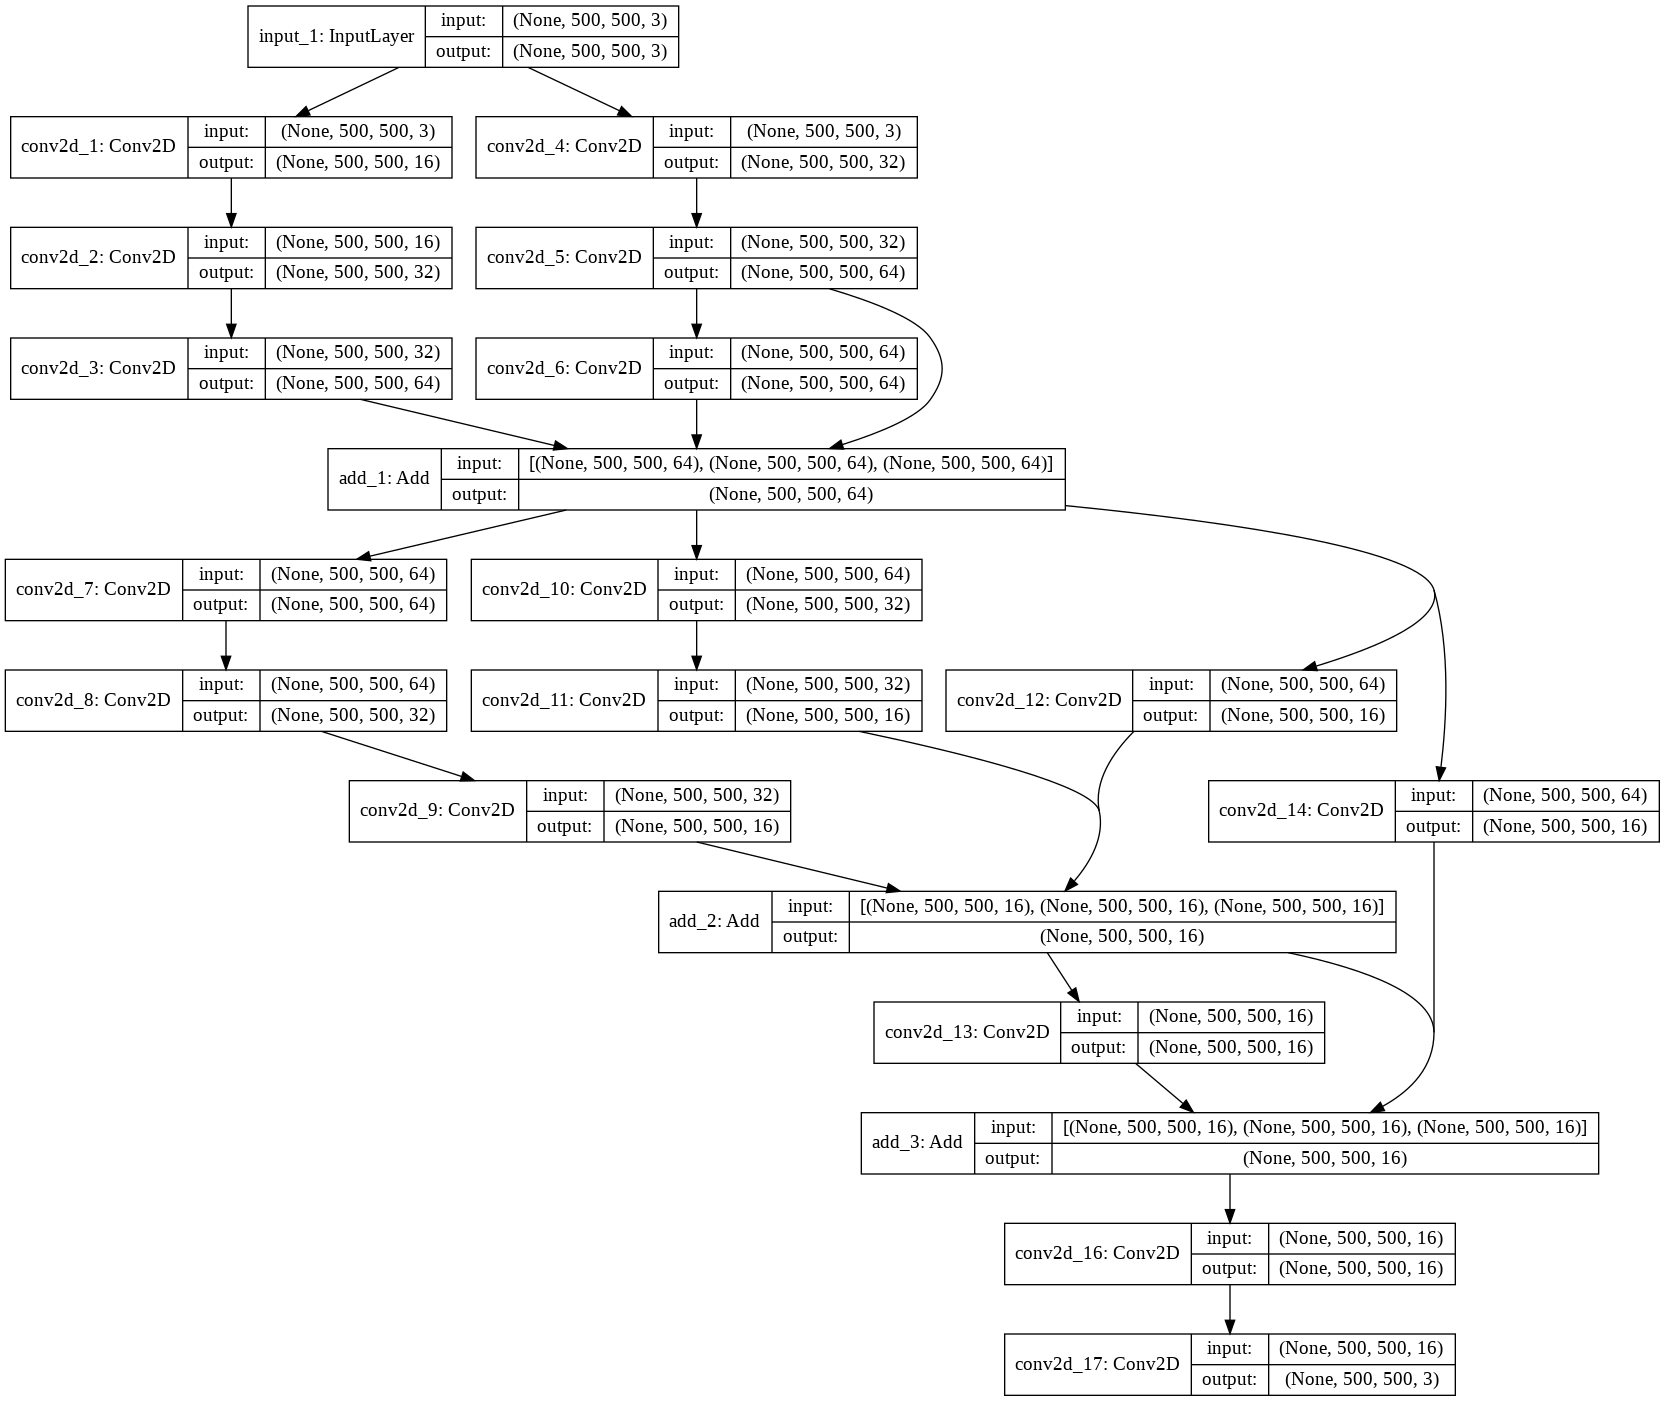

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dark_frames,clean_frames,  test_size=0.2, random_state=42)

In [26]:
history = Model_Enhancer.fit(x_train,y_train,epochs=10,verbose=1,steps_per_epoch=39,shuffle=True,validation_data=(x_test, y_test))

Epoch 1/10
39/39 [==============================] - 8s 215ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 2/10
39/39 [==============================] - 8s 215ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 3/10
39/39 [==============================] - 8s 215ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 4/10
39/39 [==============================] - 8s 215ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 5/10
39/39 [==============================] - 8s 215ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 6/10
39/39 [==============================] - 8s 215ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 7/10
39/39 [==============================] - 8s 216ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 8/10
39/39 [==============================] - 8s 216ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 9/10
39/39 [==============================] - 8s 216ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 10/10
19/39 [=============>................] - ETA: 4s - loss: 0.0036WARNING:tensorflow:Your i

2024-02-29 10:26:42.998858: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15661508376254830994
2024-02-29 10:26:42.998906: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 13776328753575232944


39/39 [==============================] - 4s 109ms/step - loss: 0.0036 - val_loss: 0.0036


In [27]:
k = Model_Enhancer.predict(x_test)

1/2 [==============>...............] - ETA: 0s

2024-02-29 10:27:08.664701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 258ms/step


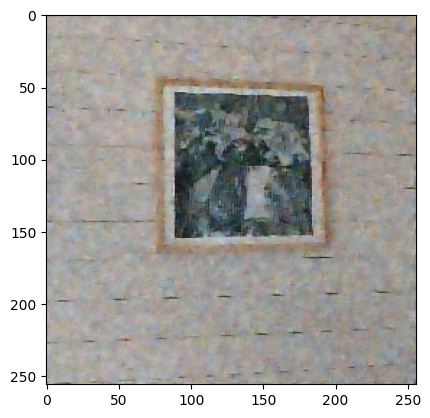

In [31]:
plt.imshow(k[9])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


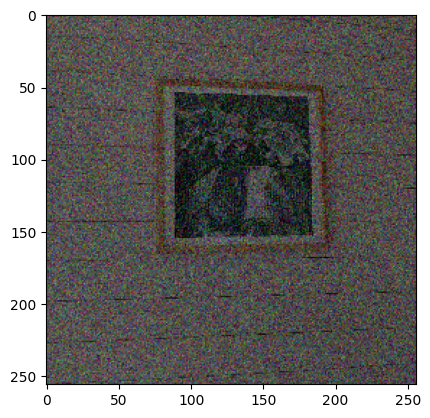

In [32]:
plt.imshow(x_test[9])

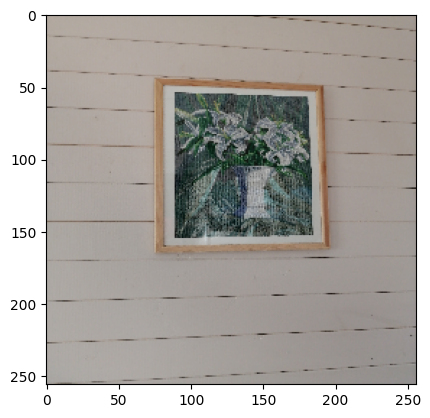

In [33]:
plt.imshow(y_test[9])

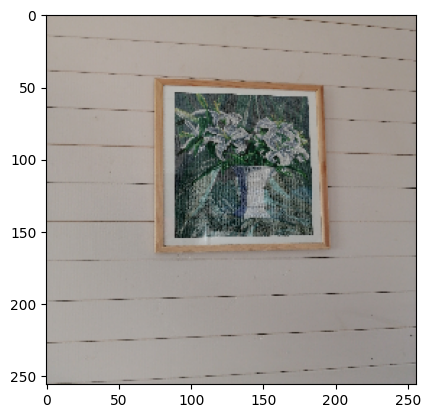

In [71]:
l = darken_image(y_test[9], darken_factor=0.999) 
plt.imshow(l)

1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


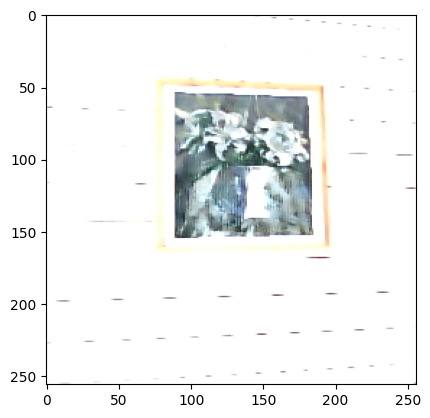

In [72]:
single_sample = np.expand_dims(l, axis=0)
result = Model_Enhancer.predict(single_sample)
plt.imshow(result[0])

dynamic dark patterns

In [83]:
clean_frames = []
dark_frames = []
good_frames = 'archive/sharp'

# Function to darken an image
def darken_image(image_array, darken_factor):
    image = Image.fromarray((image_array * 255).astype('uint8'))
    enhancer = ImageEnhance.Brightness(image)
    darkened_image = enhancer.enhance(darken_factor)
    return tf.keras.preprocessing.image.img_to_array(darkened_image).astype('float32') / 255

target_size = (256, 256)

for file in tqdm(sorted(os.listdir(good_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image_path = os.path.join(good_frames, file)
        
        # Load the image and resize to target size
        original_image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
        original_image_array = tf.keras.preprocessing.image.img_to_array(original_image).astype('float32') / 255
        
        # Darken the image and resize to target size
        darkened_image = darken_image(original_image_array, darken_factor=np.random.choice([0.5,0.9]))  # Adjust the darken factor as needed randomly
        #darkened_image = darkened_image + (0.1) * np.random.normal(size=darkened_image.shape)
        
        # Append the original and darkened images to their respective lists
        clean_frames.append(original_image_array)
        dark_frames.append(darkened_image)

# Convert lists to NumPy arrays
clean_frames = np.array(clean_frames)
dark_frames = np.array(dark_frames)

100%|█████████████████████████████████████████| 350/350 [00:05<00:00, 62.62it/s]


In [85]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dark_frames,clean_frames,  test_size=0.2, random_state=42)

In [91]:
history = Model_Enhancer.fit(x_train,y_train,epochs=25,verbose=1,steps_per_epoch=39,shuffle=True,validation_data=(x_test, y_test))

Epoch 1/25
39/39 [==============================] - 8s 215ms/step - loss: 0.0142 - val_loss: 0.0189
Epoch 2/25
39/39 [==============================] - 8s 215ms/step - loss: 0.0129 - val_loss: 0.0133
Epoch 3/25
39/39 [==============================] - 8s 215ms/step - loss: 0.0140 - val_loss: 0.0125
Epoch 4/25
39/39 [==============================] - 8s 215ms/step - loss: 0.0126 - val_loss: 0.0132
Epoch 5/25
39/39 [==============================] - 8s 215ms/step - loss: 0.0116 - val_loss: 0.0129
Epoch 6/25
39/39 [==============================] - 8s 215ms/step - loss: 0.0111 - val_loss: 0.0119
Epoch 7/25
39/39 [==============================] - 8s 215ms/step - loss: 0.0117 - val_loss: 0.0119
Epoch 8/25
39/39 [==============================] - 8s 216ms/step - loss: 0.0114 - val_loss: 0.0120
Epoch 9/25
39/39 [==============================] - 8s 215ms/step - loss: 0.0120 - val_loss: 0.0139
Epoch 10/25
39/39 [==============================] - 8s 216ms/step - loss: 0.0112 - val_loss: 0.0183

2024-02-29 13:49:13.731532: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15661508376254830994
2024-02-29 13:49:13.731543: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 13776328753575232944


39/39 [==============================] - 6s 156ms/step - loss: 0.0093 - val_loss: 0.0111


In [92]:
k = Model_Enhancer.predict(x_test)

2/2 [==============================] - 0s 285ms/step


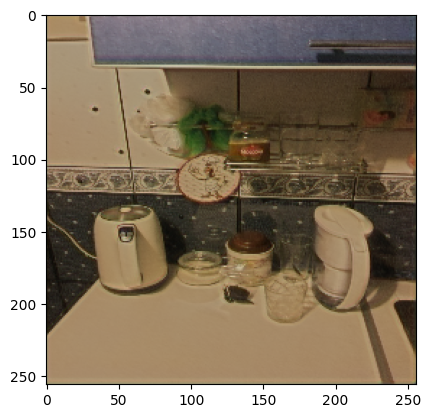

In [104]:
plt.imshow(k[3])

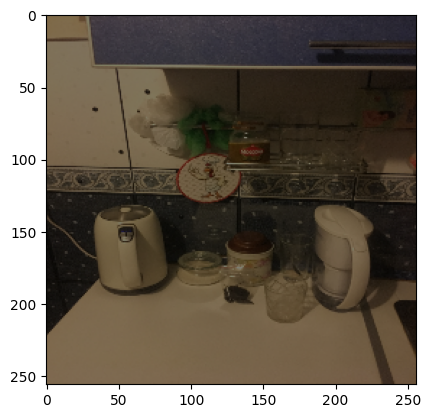

In [103]:
plt.imshow(x_test[3])

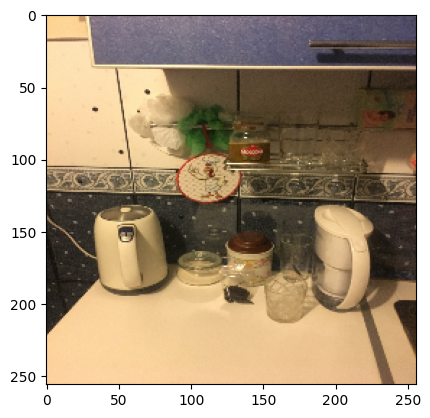

In [106]:
plt.imshow(y_test[3])

1/1 [==============================] - 0s 15ms/step


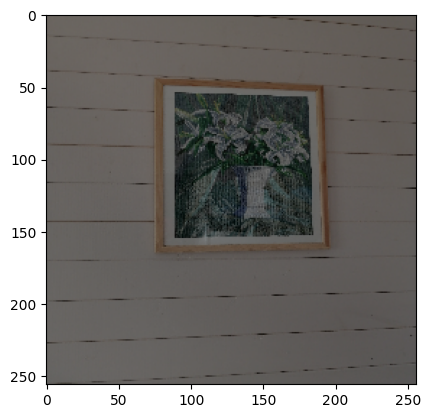

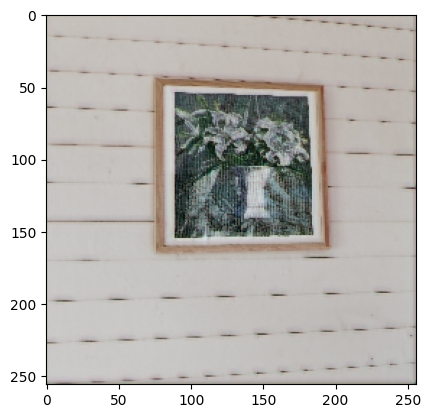

In [121]:
l = darken_image(y_test[9], darken_factor=0.6) 
single_sample = np.expand_dims(l, axis=0)
result = Model_Enhancer.predict(single_sample)
plt.imshow(l)
plt.show()
plt.imshow(result[0])

1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


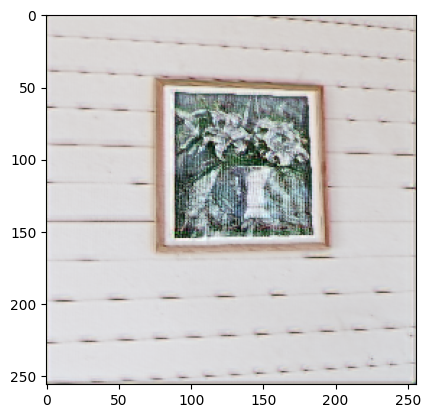

In [122]:
result = Model_Enhancer.predict(result)
plt.imshow(result[0])

1/1 [==============================] - 0s 15ms/step


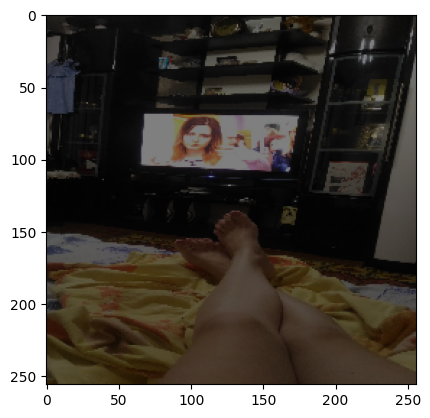

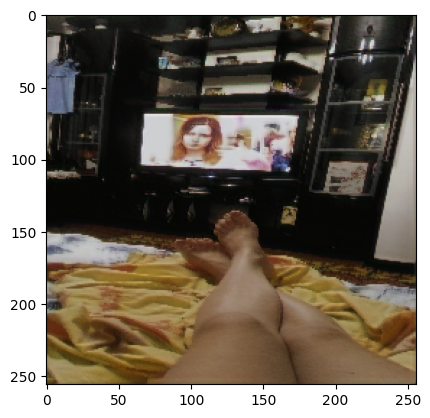

In [129]:
single_sample = np.expand_dims(x_train[0], axis=0)
result = Model_Enhancer.predict(single_sample)
plt.imshow(x_train[0])
plt.show()
plt.imshow(result[0])

1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


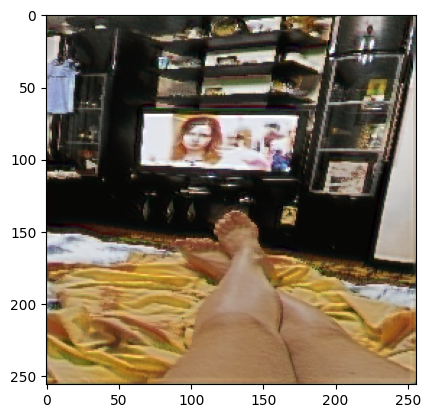

In [130]:
result = Model_Enhancer.predict(result)
plt.imshow(result[0])